<a href="https://colab.research.google.com/github/Kevin-Yang130/ML-LinkedIn-Applications-Predictor/blob/main/LinkedIn_Job_Postings_CIS545_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CIS 5450 Final Project - Predicting the number of applications to jobs**
**Vanshika Sriram, Kevin Yang Li, Leo Zhou**

#**Part 0: Introduction**
The goal of this project is to gain a deeper understanding of the job postings dataset through comprehensive exploratory data analysis (EDA) and implementing various regression models to predict the number of applies a job posting will get based on factors such as location, skills, salary, views, and the presence of a remote option.

Ultimately, we can understand what factors make a job posting "popular," and aim to uncover patterns and insights that will inform us on how, given the state of the job market, people are approaching job applications.



# **Part 1: Data Loading, Preprocessing, and Feature Engineering**

##**1.1 Importing libraries and dataset**

In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import math
import kagglehub
import re
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch import nn
from scipy import stats
import optuna.visualization as vis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin

In [ ]:
homePath = kagglehub.dataset_download("arshkon/linkedin-job-postings")
postingsPath = homePath + "/postings.csv"
postings_df = pd.read_csv(postingsPath)

skillsPath = homePath + "/jobs/job_skills.csv"
skills_df = pd.read_csv(skillsPath)

skillsMappingPath = homePath + "/mappings/skills.csv"
skillsMapping_df = pd.read_csv(skillsMappingPath)

companiesPath = homePath + "/companies/companies.csv"
companies_df = pd.read_csv(companiesPath)

##**1.2 Data Cleaning**
- **Objective**: Ensure data quality by addressing inconsistencies, errors, and missing information.
- **Actions**:
  - **Remove Unnecessary Information**: Eliminate repeated job postings, unnecessary columns, null values.
  - **Handle Missing Data**: NaN in the column `applies` indicate that these jobs have no applications yet so we replace with 0. NaN in the column `remote_allowed` indicates that there is no remote option indicated or available, so we replace with 0 to indicate 'False' "
  - **Adjust `normalized_salary` column**: Change the column name to 'posted_salary'. If salary data is posted, we change this row to a 1 to indicate 'True'. If salary data isn't posted, we change this to 0 to indicate 'False'.


In [ ]:
# dropping unecessary columns
cols_to_drop = ['med_salary', 'posting_domain', 'application_url', 'currency',
                'application_type', 'skills_desc', 'closed_time', 'sponsored',
                'fips', 'zip_code', 'formatted_experience_level', 'description',
                'original_listed_time','job_posting_url', 'expiry','listed_time',
                'work_type', 'max_salary', 'min_salary', 'pay_period', 'compensation_type']
postings_df.drop(cols_to_drop, axis=1, inplace=True)
postings_df.rename(columns = {
    'normalized_salary' : 'salary'
})

# replaces NaN values with 0's to make the data make sense in context
postings_df.fillna({
     'remote_allowed': 0,
     'applies': 0},
  inplace=True)

# drops null company names
postings_df = postings_df[postings_df['company_name'].notna()].reset_index(drop=True)

#replacing normalized salary
postings_df['normalized_salary'] = postings_df['normalized_salary'].apply(lambda x: 0 if pd.isna(x) else 1)
postings_df.rename(columns={'normalized_salary':'posted_salary'}, inplace=True)

##**1.3 Joining Data Tables**
- **Objective**: We are joining 2 additional tables with our main dataframe `postings_df` to get data on each job's skills and each job posting's company size to be used in our analyses. Below is a description of each of the additional tables we are joining:

1. `companies_df`: contains various information about each company listed in each job posting. We are only interested in the `company_size` column, which ranks each company by size from 1-7, with 7 being the largest.
2. `skills_df`: contains columns `job_id` and `skill_abr`
3. `skillsMapping_df`: maps `skill_abr` to `skill_name`

These are the steps we will take to join these tables with `postings_df`
1. Inner join `skills_df` with `skillsMapping_df` on the `skill_abr` column
2. Inner join `skills_df` with `postings_df` on the `job_id` column. Then inner join `skills_df` to this dataframe on the `company_id` column to get `postings_final_df`.
3. Drop all other unnecessary columns. These are 'name', 'description', 'state', 'country', 'city', 'zip_code', 'address', 'url', 'company_name'. Then drop all NaN values


In [ ]:
skills_df = skills_df.merge(skillsMapping_df, on='skill_abr')

In [ ]:
jobs_and_skills_df = postings_df.merge(skills_df, on='job_id')

In [ ]:
postings_final_df= jobs_and_skills_df.merge(companies_df, on='company_id')
postings_final_df.drop(columns=['name', 'description', 'state', 'country', 'city', 'zip_code', 'address', 'url', 'company_name'], inplace=True)

In [ ]:
postings_final_df.dropna(inplace=True)
postings_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191887 entries, 0 to 203163
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   job_id               191887 non-null  int64  
 1   title                191887 non-null  object 
 2   location             191887 non-null  object 
 3   company_id           191887 non-null  float64
 4   views                191887 non-null  float64
 5   formatted_work_type  191887 non-null  object 
 6   applies              191887 non-null  float64
 7   remote_allowed       191887 non-null  float64
 8   posted_salary        191887 non-null  int64  
 9   skill_abr            191887 non-null  object 
 10  skill_name           191887 non-null  object 
 11  company_size         191887 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 19.0+ MB


##**1.4 Feature Engineering**

**Objective**: In this section we have 3 major goals
1. **Create broader 'skill' categories**
2. **Group each location into 'tiers' based on desirability and popularity**
3. **Encode the `skill` column**

We will go into more depth about our motivation and methods for each of these steps in each subsection.

###**1.4.1 Create broader skill categories**
We have 35 different skills, and each job has multiple skills. This many categories will be difficult and time consuming to encode, and might result in an overly complex and not generalizable model. Thus, we want to group these 35 skills into broader categories:
1. Creative and Communication Skills
2. Business, Finance, and Management
3. Education and Training
4. Analysis and Research
5. Technology and Engineering
6. Customer Service
7. Health, Legal, and HR
8. Supply Chain and Operations
9. Other

We are achieving this by first creating a dictionary that maps each broad skill category to the individual skill abbreviation. We then map our `skill` column based on this dictionary and drop the unnecessary columns `skill_abr` and `skill_name`


In [ ]:
# Mapping dictionary for skill_name to broader categories
skill_mapping = {
    # Creative and Communication Skills
    'ART': 'Creative and Communication Skills','DSGN': 'Creative and Communication Skills', 'ADVR': 'Creative and Communication Skills',
    'WRT': 'Creative and Communication Skills', 'MRKT': 'Creative and Communication Skills', 'PR': 'Creative and Communication Skills',

    # Business, Finance, and Management
    'GENB': 'Business, Finance, and Management', 'PRJM': 'Business, Finance, and Management', 'STRA': 'Business, Finance, and Management',
    'MGMT': 'Business, Finance, and Management', 'BD': 'Business, Finance, and Management', 'PRDM': 'Business, Finance, and Management',
    'CNSL': 'Business, Finance, and Management','FIN': 'Business, Finance, and Management','ACCT': 'Business, Finance, and Management',
    'ADM': 'Business, Finance, and Management',

    # Education and Training
    'EDU': 'Education and Training','TRNG': 'Education and Training',

    # Analysis and Research
    'ANLS': 'Analysis and Research','RSCH': 'Analysis and Research','SCI': 'Analysis and Research',

    # Technology and Engineering
    'ENG': 'Technology and Engineering', 'QA': 'Technology and Engineering','IT': 'Technology and Engineering',

    # Customer Service
    'CUST': 'Customer Service','SALE': 'Customer Service',

    # Health, Legal, and HR
    'HCPR': 'Health, Legal, and HR','LGL': 'Health, Legal, and HR','HR': 'Health, Legal, and HR',

    # Supply Chain and Operations
    'DIST': 'Supply Chain and Operations','PRCH': 'Supply Chain and Operations','SUPL': 'Supply Chain and Operations', 'MNFC': 'Supply Chain and Operations', 'PROD': 'Supply Chain and Operations',

    # Other
    'OTHR': 'Other'
}

In [ ]:
postings_final_df['skill'] = postings_final_df['skill_abr'].map(skill_mapping).fillna('Other')

postings_final_df.drop(columns = ['skill_name','skill_abr'], inplace=True)

###**1.4.2 Group location into 'tiers' based on popularity**
There are numerous different locations and no standard method of how the locations are phrased (e.x. Texas can be listed as 'TX' or 'Texas'). We want to reduce the number of locations and group them by how popular they are, with 1 being the most popular and 3 being the least. Thus, we can use location as an ordinal feature in our model.

We first define tier 1 and tier 2 cities using a dictionary. All other locations not mentioned in this mapping are considered tier 3.

We then create **regex patterns** for Tier 1 and 2 cities to see if the regex appears in each row of the location column. Based on whether there is a match or not, we convert each location into the number 1, 2, and 3.

In [ ]:
tier_1_cities = [
    "New York", "Los Angeles", "Chicago", "Houston", "San Francisco",
    "Washington", "Dallas", "Miami", "Boston", "Atlanta", "Seattle"
]

tier_2_cities = [
    "Austin", "San Jose", "San Diego", "Phoenix", "Denver",
    "Philadelphia", "Minneapolis", "Detroit", "Charlotte",
    "Tampa", "Orlando", "Portland", "Las Vegas", "Salt Lake City"
]

In [ ]:
#create regex patterns for Tier 1 and Tier 2 cities
tier_1_pattern = r'|'.join([re.escape(city) for city in tier_1_cities])
tier_2_pattern = r'|'.join([re.escape(city) for city in tier_2_cities])

#function to categorize location into tiers
def categorize_location_with_regex(location):
    if re.search(tier_1_pattern, location, re.IGNORECASE):
        return 1
    elif re.search(tier_2_pattern, location, re.IGNORECASE):
        return 2
    else:
        return 3

postings_final_df['location'] = postings_final_df['location'].apply(categorize_location_with_regex)

###**1.4.3 Encoding Columns**
In our dataset, the skill column contains categorical data representing 9 distinct skills. Since machine learning models typically require numerical inputs, we need to transform these categories into a format that the model can understand.

To achieve this, we use **One-Hot Encoding**, which is a method for converting categorical data into a numerical format without imposing an ordinal relationship between the categories.

In [ ]:
#0ne-Hot Encode the 'skill' column
one_hot_encoded_skills = pd.get_dummies(postings_final_df['skill'], prefix='skill')

#combine with the original DataFrame
encoded_postings_df = pd.concat([postings_final_df, one_hot_encoded_skills], axis=1)

#convert all boolean columns to integers
boolean_columns = encoded_postings_df.select_dtypes(include='bool').columns
encoded_postings_df[boolean_columns] = encoded_postings_df[boolean_columns].astype(int)

###**1.4.4 Some more data cleaning**
Given that each job can fall under multiple skill categories, we have a lot of duplicate job postings. We want to only have one row for each job posting, so we are grouping by job_id and aggregating each skill column to ensure that if that job_id possesses a skill, a 1 will appear in that skill's column.

We then drop any other unnecessary columns that will not be used in our predictive model. The final dataframe we end up with has these columns:
1. location (ordinal)
2. views (numerical)
3. applies (numerical, target)
4. remote_allowed (binary encoded)
5. posted_salary (binary encoded)
6. company_size (ordinal)
7. skill_Analysis and Research    
8. skill_Business, Finance, and Management
9. skill_Creative and Communication Skills
10. skill_Customer Service
11. skill_Education and Training
12. skill_Health, Legal, and HR  
13. skill_Other
14. skill_Supply Chain and Operations
15. skill_Technology and Engineering

In [ ]:
# Group the DataFrame by job_id and aggregate columns
encoded_postings_df = encoded_postings_df.groupby('job_id').agg({
    'title': 'first',
    'location': 'first',
    'company_id': 'first',
    'views': 'mean',
    'formatted_work_type': 'first',
    'applies': 'mean',
    'remote_allowed': 'mean',
    'posted_salary': 'mean',
    'company_size': 'mean',
    'skill': lambda x: ', '.join(set(x)),

    #for one-hot encoded skill columns, take the max value
    'skill_Analysis and Research': 'max',
    'skill_Business, Finance, and Management': 'max',
    'skill_Creative and Communication Skills': 'max',
    'skill_Customer Service': 'max',
    'skill_Education and Training': 'max',
    'skill_Health, Legal, and HR': 'max',
    'skill_Other': 'max',
    'skill_Supply Chain and Operations': 'max',
    'skill_Technology and Engineering': 'max',
}).reset_index()

encoded_postings_df.drop(columns=['skill', 'job_id', 'title', 'company_id', 'formatted_work_type'], inplace=True)
encoded_postings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114453 entries, 0 to 114452
Data columns (total 15 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   location                                 114453 non-null  int64  
 1   views                                    114453 non-null  float64
 2   applies                                  114453 non-null  float64
 3   remote_allowed                           114453 non-null  float64
 4   posted_salary                            114453 non-null  float64
 5   company_size                             114453 non-null  float64
 6   skill_Analysis and Research              114453 non-null  int64  
 7   skill_Business, Finance, and Management  114453 non-null  int64  
 8   skill_Creative and Communication Skills  114453 non-null  int64  
 9   skill_Customer Service                   114453 non-null  int64  
 10  skill_Education and Training    

# **Part 2: EDA**
Now that we have our cleaned data, we want to gather some insights into our data and the key features in our model. We have 3 main goals with this:
1. **Find and adjust for outliers**
2. **Understand the differences in applies based on skill category**
3. **Understand whether remote vs non-remote jobs have differences in applies via hypothesis testing**
4. **Produce a correlation matrix**

## **2.1 Removing Outliers**


We first are creating a histogram of the number of applications across all job postings to see how the data is spread out.

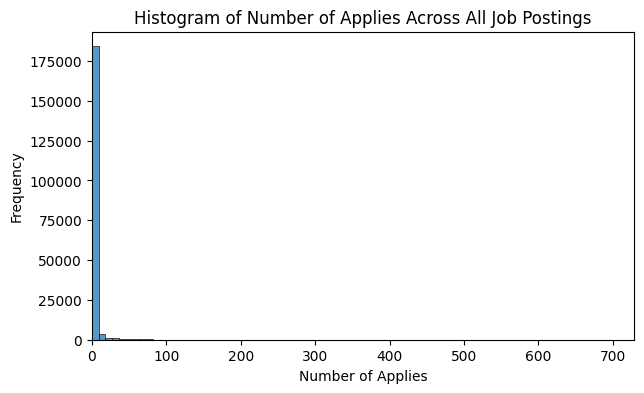

In [ ]:
plt.figure(figsize=(7, 4))
sns.histplot(postings_final_df['applies'], bins=80)
plt.xlim(postings_final_df['applies'].min(), postings_final_df['applies'].max())
plt.xlabel('Number of Applies')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Applies Across All Job Postings')
plt.show()

**Key Takeaways**: From this histogram, we can see that there is a very large range of data. Given that these are linkedin job postings, there is a chance that some of these jobs have a large number of applies due to various reasons, including fraud. We want to ensure that we are avoiding these outliers.

To do this, we filter our data based on z-scores. After finding the z-scores of each of the datapoints, we take the data that falls within 2 standard deviations of the mean to capture 95% of our data. This method ensures we eliminate extreme values

In [ ]:
postings_final_df['z_score'] = stats.zscore(postings_final_df['applies'])
filtered_df = postings_final_df[abs(postings_final_df['z_score']) < 2]

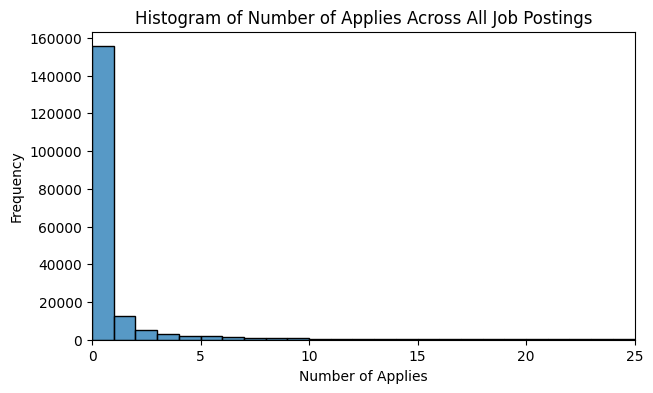

In [ ]:
plt.figure(figsize=(7, 4))
sns.histplot(filtered_df['applies'], bins=25)
plt.xlim(filtered_df['applies'].min(), filtered_df['applies'].max())
plt.xlabel('Number of Applies')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Applies Across All Job Postings')
plt.show()

**Key takeaways** From this graph we can see that we are capturing a more reasonable range of data, with the range spanning from 0-25 rather than 0-725 applies.

## **2.2 Understanding the number of applications that a job posting gets based on the skills**


We are interested in finding out whether some skills categoires get more applies than others. We can determine this by creating a box plot of the average number of applies for each skill category.

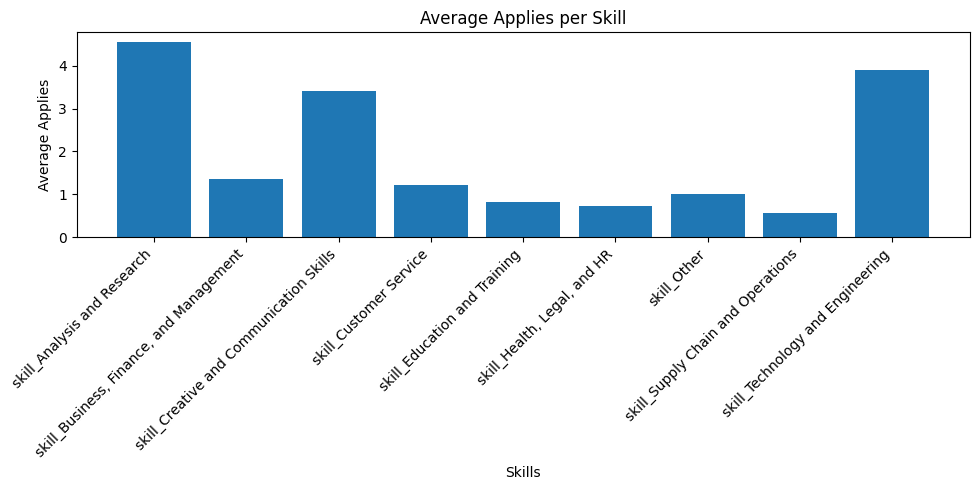

In [ ]:
skills = [
    "skill_Analysis and Research",
    "skill_Business, Finance, and Management",
    "skill_Creative and Communication Skills",
    "skill_Customer Service",
    "skill_Education and Training",
    "skill_Health, Legal, and HR",
    "skill_Other",
    "skill_Supply Chain and Operations",
    "skill_Technology and Engineering",
]

avg_applies_per_skill = {skill: encoded_postings_df.loc[encoded_postings_df[skill] == 1, 'applies'].mean() for skill in skills}

plt.figure(figsize=(10, 5))
plt.bar(avg_applies_per_skill.keys(), avg_applies_per_skill.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Skills")
plt.ylabel("Average Applies")
plt.title("Average Applies per Skill")
plt.tight_layout()
plt.show()

**Key Takeaways**: Analysis and research, tech and engineering, and creative jobs appear to get the most applies. On the other hand, supply chain and operation, education, and health/legal/HR roles get the least amount of applies. What we found interesting was that business oriented roles also have less applies than other fields, which was opposite to our initial thinking that this would be a more popular field

## **2.3 Remote vs. Non-remote Jobs**
Given the COVID-19 pandemic, many jobs made the switch to remote options. We've seen this trend appear for more and more jobs even post pandemic, and many people prefer this option. Thus we were interested in determining whether there is a statistically significant difference in the number of applications to jobs that are remote and non remote. We do **hypothesis testing** to achieve this.

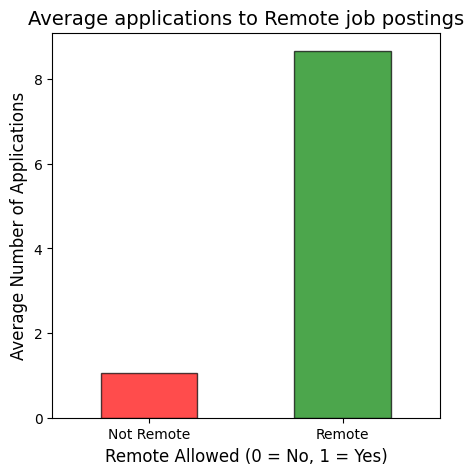

In [ ]:
mean_views = postings_df.groupby('remote_allowed')['applies'].mean()

plt.figure(figsize=(5, 5))
mean_views.plot(kind='bar', color=['red', 'green'], alpha=0.7, edgecolor='k')
plt.title('Average applications to Remote job postings', fontsize=14)
plt.xlabel('Remote Allowed (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Average Number of Applications', fontsize=12)
plt.xticks([0, 1], labels=["Not Remote", "Remote"], rotation=0)
plt.show()

**Key Takeaways**: From this plot, it is clear that there is a difference in the average number of applies between remote and non remote jobs, but **hypothesis testing** is needed to confirm whether this is a statistically significant difference**

### **2.3.1 Permutation Testing: Remote Jobs and Views**

**1. Simulating the Null Hypothesis**
- Combine the `applies` column from both groups (remote and non-remote) into a single dataset.
- Randomly shuffle the `remote_allowed` labels to break the association between job type and views.

**2. Generate Permutations**
- Reassign the shuffled labels to the original dataset to form a "permuted" dataset.
- Recalculate the difference in mean views between the two groups for the permuted dataset.
- Repeat this process many times (e.g., 1,000 permutations) to build a distribution of mean differences under the null hypothesis.

**3. Compare Observed Statistic to Null Distribution**
- Plot the distribution of permuted mean differences (null distribution).
- Mark the observed statistic on the plot to visualize how extreme it is compared to the null distribution.

**4. Calculate the P-Value**
- Compute the **p-value** as:
  \[
  \text{p-value} = \frac{\text{Number of permuted statistics as extreme as (or more extreme than) the observed statistic}}{\text{Total number of permutations}}
  \]
- Interpret the p-value:
  - **If p-value ≤ 0.05**: Reject the null hypothesis; the job type (remote or non-remote) significantly influences the number of views.
  - **If p-value > 0.05**: Fail to reject the null hypothesis; there is no significant evidence that job type influences the number of views.




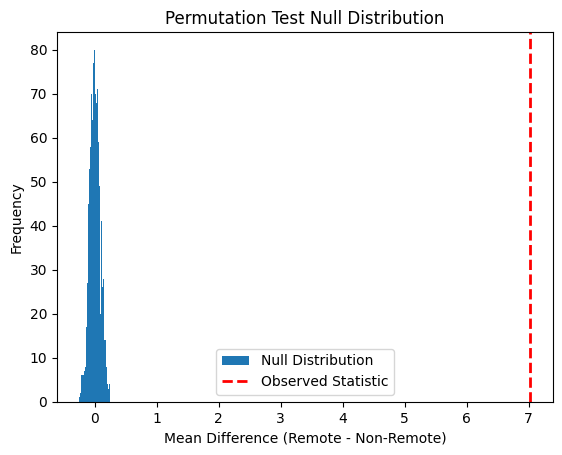

Observed Statistic: 7.028533595023681
P-Value: 0.0
Reject the null hypothesis: Remote jobs significantly influence the number of applies.


In [ ]:
num_permutations = 1000
significance_level = 0.05

#observed statistic
observed_mean_remote = postings_final_df.loc[postings_final_df["remote_allowed"] == 1, "applies"].mean()
observed_mean_non_remote = postings_final_df.loc[postings_final_df["remote_allowed"] == 0, "applies"].mean()
observed_statistic = observed_mean_remote - observed_mean_non_remote

#shuffle labels for null hypothesis
views = postings_final_df["applies"].values
labels = postings_final_df["remote_allowed"].values

#generate permutations
permuted_statistics = []
for _ in range(num_permutations):
    shuffled_labels = np.random.permutation(labels)
    permuted_mean_remote = views[shuffled_labels == 1].mean()
    permuted_mean_non_remote = views[shuffled_labels == 0].mean()
    permuted_statistic = permuted_mean_remote - permuted_mean_non_remote
    permuted_statistics.append(permuted_statistic)

#compare observed statistic to null
plt.hist(permuted_statistics, bins=30, label='Null Distribution')
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
plt.xlabel('Mean Difference (Remote - Non-Remote)')
plt.ylabel('Frequency')
plt.title('Permutation Test Null Distribution')
plt.legend()
plt.show()

#calculate P-Value
extreme_count = np.sum(np.abs(permuted_statistics) >= np.abs(observed_statistic))
p_value = extreme_count / num_permutations

print(f"Observed Statistic: {observed_statistic}")
print(f"P-Value: {p_value}")

if p_value <= significance_level:
    print("Reject the null hypothesis: Remote jobs significantly influence the number of applies.")
else:
    print("Fail to reject the null hypothesis: No significant evidence that remote jobs influence the number of applies.")

**Key Takeaways** The p-value generated from this hypothesis test is practically 0, indicating very strongly that we can reject the null hypothesis. Remote jobs significantly influence the number of applies. We predict that this will play a major factor in terms of feature importance for our tree-based models.

## **2.4 Correlation Matrix**
To determine whether we should use multiple linear regression as a baseline model, we generate a correlation matrix to check for the linear relationship between each feature.

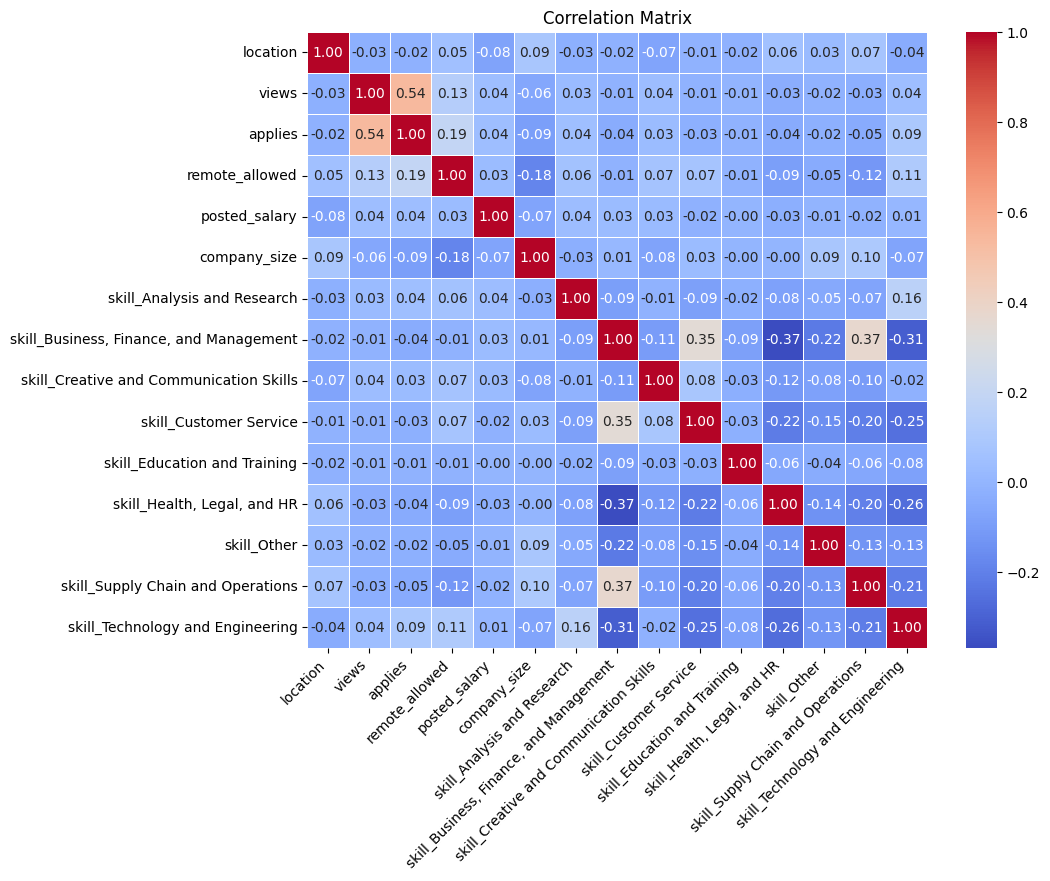

In [ ]:
correlation_matrix = encoded_postings_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

**Key Takeaways** The low correlation between most features and the number of applies indicates that this is not a linear relationship. We are also surprised to see that the remote option has a low correlation with the number of applies, especially after our hypothesis testing showed otherwise. This indicates to us that we cannot use MLR as a baseline model, and should look to alternative regression models, such as decision-tree based ones.

# **Part 3. Model Implementation, Assessment, and Hyperparameter Tuning**

## **3.1 Baseline Model: Random Forest Regressor**
**Motivation:** Given the results of our correlation matrix, we can see that we need a non-linear model for our purposes. Thus, a random forest decision tree made sense to us to start our modeling with.

**Goal:** To predict the number of applications a job posting will get based on other features.

**Target variable**: The Number of applications a job posting gets (`applies`)   
**Features**: `location`, `views`, `remote_allowed`, `posted_salary`, `company_size`, `skills`

**Evaluation Metrics**: We chose to evalute our model with **R²** and **MAE**.

R² measures how well the model explains the variance in the number of applications based on features like location, whether the salary is posted or not, and other features. MAE measures the average error in predictions, showing how far the model's guesses deviate from actual values. Together, R² highlights the model's ability to capture patterns and predictive power, while MAE provides a practical measure of prediction accuracy.

**Shortcomings and biases**: Given that our data for the number of applies is heavily left skewed, it may show bias towards this.

In [ ]:
X = encoded_postings_df.drop(columns=['applies'])
y = encoded_postings_df['applies']

#train test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#training the model:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

#evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
train_r2 = random_forest.score(X_train, y_train)
test_r2 = random_forest.score(X_test, y_test)

mse, mae, train_r2, test_r2

(52.316211779437175, 1.069868113385528, 0.9490948314611386, 0.6975275411314743)


   **Training R² (0.949):** The model explains 94.9% of the variance in the training data, suggesting a strong fit to the training set. However, the
   significant gap between training and test R² indicates potential **overfitting**. We will further check and confirm for overfitting in the **cross validation test**.

   **Test R² (0.697):** The model explains 69.7% of the variance in the test set, reflecting reasonable predictive power but highlighting room for improvement.

   **MAE (1.069):** On average, the model’s predictions deviate by approximately 1.07 applications, providing an interpretable measure of prediction accuracy.


### **3.1.1 Cross Validation**
#### Cross-Validation for Random Forest

To evaluate the performance of our Random Forest model, we performed a **5-fold cross-validation test**. By averaging the R² scores across all folds, we get a more robust estimate of the model's ability to generalize to unseen data. This is particularly important for Random Forests, as their performance can vary depending on the specific training data

- **Purpose**: Cross-validation helps evaluate the model’s ability to generalize to unseen data by testing it on different subsets of the dataset.
- **Metric Used**: We used **R² score** to assess the proportion of variance explained by the model.

- **Average R²**: The average R² score across all folds is **0.6756**, indicating that the model explains about 67.56% of the variance in the target variable on average.

This approach ensures a more reliable assessment of the model's performance than a single train-test split.


In [ ]:
k = 5
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error)
}

#perform 5-fold cross-validation with both metrics
cv_results = cross_validate(
    random_forest,
    X,
    y,
    cv=k,
    scoring=scoring,
    return_train_score=True
)

print("Train R² Scores (per fold):", cv_results['train_r2'])
print("Test R² Scores (per fold):", cv_results['test_r2'])
print("Train MAE Scores (per fold):", cv_results['train_mae'])
print("Test MAE Scores (per fold):", cv_results['test_mae'])

print("\nSummary Metrics:")
print("Mean Train R²:", cv_results['train_r2'].mean())
print("Mean Test R²:", cv_results['test_r2'].mean())
print("Mean Train MAE:", cv_results['train_mae'].mean())
print("Mean Test MAE:", cv_results['test_mae'].mean())

Train R² Scores (per fold): [0.9547499  0.94754751 0.95072156 0.95346332 0.95241495]
Test R² Scores (per fold): [0.5390533  0.72594232 0.66971356 0.58252026 0.41451885]
Train MAE Scores (per fold): [0.47987815 0.42237561 0.4524348  0.4799721  0.58238726]
Test MAE Scores (per fold): [1.12468507 1.59251233 1.35496218 1.12874712 0.24340327]

Summary Metrics:
Mean Train R²: 0.9517794467877669
Mean Test R²: 0.5863496575950763
Mean Train MAE: 0.48340958350678287
Mean Test MAE: 1.0888619952811962


**Train R² Scores:** Averaged 0.951, indicating that the model fits the training data very well, explaining over 95% of the variance.
However, high Train R² values also suggest potential overfitting, as the model captures training patterns too closely.

**The Test R² scores:** Averaged 0.563, with values ranging from 0.414 to 0.725 across folds.
This variability in Test R² highlights sensitivity to data splits, with the model struggling to generalize consistently across different subsets of the dataset.

**Train MAE:** Averaged 0.483, while Test MAE averaged 1.088.
This gap indicates that while the model performs well on the training data, its predictions deviate significantly more on unseen data, further suggesting overfitting.


### **3.1.2 Feature Importance**

**Feature importance** in a Random Forest quantifies the contribution of each feature to the model's predictions. The importance score reflects how much each feature reduces the impurity across all the trees in the forest.

- **Why It Matters**:
  - Feature importance helps us understand which features are most influential in making predictions.
  - It can guide feature selection by identifying irrelevant or less impactful features, simplifying the model and improving interpretability.

- **Key Considerations**:
  - Random Forests are ensemble models, so the importance scores represent average contributions across many trees.
  - Features with high cardinality (e.g., many unique values) or high correlation with other features can sometimes appear more important than they truly are.


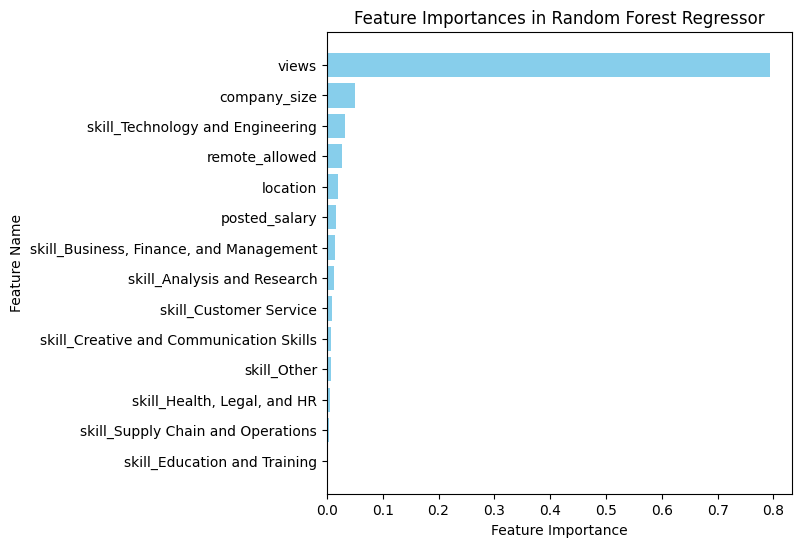

In [ ]:
feature_importances = random_forest.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importances in Random Forest Regressor')
plt.gca().invert_yaxis()
plt.show()

### **3.1.3 Grid Search for Hyperparameter Tuning**
For our Random Forest model, which predicts job applications, we performed a Grid Search to optimize key hyperparameters. By doing so, we aim to:
- Improve the model's generalizability (reduce overfitting or underfitting),
- Achieve higher accuracy in predictions,
- Ensure the model performs well on unseen data.

The best hyperparameters found during Grid Search will be used to train the final model, improving its ability to predict the number of job applications accurately.

By using Grid Search, we ensure that our Random Forest model is fine-tuned for optimal performance in predicting the number of applications.


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 18 candidates, totalling 90 fits


({'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100},
 0.647387062658141)

### **3.1.4 Random Forest with Hyperparameter Tuning**
After performing a Grid Search to optimize the hyperparameters of our Random Forest model, we identified the best combination of parameters to improve its performance.

**Goal:** The tuned Random Forest model aims to predict the number of job applications a posting receives with improved accuracy and generalizability, leveraging the best hyperparameter configuration obtained from the Grid Search.

We now train and evaluate the Random Forest model using these hyperparameters to assess its final performance.



In [ ]:
X = encoded_postings_df.drop(columns=['applies'])
y = encoded_postings_df['applies']

#train test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

optimized_random_forest = RandomForestRegressor(
    max_depth=15,
    max_features='sqrt',
    n_estimators=100,
)

#train the model
optimized_random_forest.fit(X_train, y_train)
optimized_y_pred = optimized_random_forest.predict(X_test)

#evaluation metrics
optimized_mse = mean_squared_error(y_test, optimized_y_pred)
optimized_mae = mean_absolute_error(y_test, optimized_y_pred)
optimized_r2 = r2_score(y_test, optimized_y_pred)

optimized_mse, optimized_mae, optimized_r2

(47.97719007990659, 1.1139734643052297, 0.7226141159789436)

In [ ]:
k = 5
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error)
}

#perform 5-fold cross-validation with both metrics
cv_results = cross_validate(
    optimized_random_forest,
    X,
    y,
    cv=k,
    scoring=scoring,
    return_train_score=True
)

print("Train R² Scores (per fold):", cv_results['train_r2'])
print("Test R² Scores (per fold):", cv_results['test_r2'])
print("Train MAE Scores (per fold):", cv_results['train_mae'])
print("Test MAE Scores (per fold):", cv_results['test_mae'])

print("\nSummary Metrics:")
print("Mean Train R²:", cv_results['train_r2'].mean())
print("Mean Test R²:", cv_results['test_r2'].mean())
print("Mean Train MAE:", cv_results['train_mae'].mean())
print("Mean Test MAE:", cv_results['test_mae'].mean())

Train R² Scores (per fold): [0.94196056 0.93409332 0.9337233  0.93435796 0.93526848]
Test R² Scores (per fold): [0.6150194  0.69836131 0.69996477 0.66197951 0.52249844]
Train MAE Scores (per fold): [0.75784593 0.64529498 0.7022599  0.75648119 0.90453978]
Test MAE Scores (per fold): [1.13860219 1.62630249 1.39585512 1.16070157 0.42352874]

Summary Metrics:
Mean Train R²: 0.9358807211172596
Mean Test R²: 0.6395646865929994
Mean Train MAE: 0.7532843558972218
Mean Test MAE: 1.1489980216372755


### **3.1.4 Conclusion**

 - After applying the optimized hyperparameters, the model's mean training R² dropped slightly to 0.936, **reflecting reduced overfitting.**
 - The mean test R² remained at 0.644, similar to the baseline model, **confirming generalizability to unseen data**.
 - The mean MAE of the optimized model was 1.14, which is on par with the baseline model but slightly lower, indicating **slight improvements in prediction accuracy**.

While hyperparameter tuning reduced overfitting, performance improvements remain marginal. Future efforts may focus on feature engineering or experimenting with alternative algorithms to enhance prediction accuracy.
















## **3.2 XGBoost Regressor**
**Motivation:** Based on the results of our Random Forest Regressor, we have reduced but are still  experiencing some overfitting. Our R^2 for the testing set is good but could also be improved. Thus, we are interseted in using an XGBoost model to see if we can generate a better model. XGBoost tends to have higher accuracy and has regularization to prevent overfitting, which is useful for our purposes.

**Goal:** To predict the number of applications a job posting will get based on other features.

**Target variable**: The Number of applications a job posting gets (`applies`)   
**Features**: `location`, `views`, `remote_allowed`, `posted_salary`, `company_size`, `skills`

**Evaluation Metrics**: We chose to evalute our model with **R²** and **MAE**.

Using R² and MAE as evaluation metrics for an XGBoost model provides complementary insights into its performance. R² measures how well the model explains the variance in the target variable, indicating its ability to capture patterns and relationships in the data. This is especially useful for XGBoost, which excels at modeling complex, nonlinear relationships. Meanwhile, MAE quantifies the average error in predictions, offering a practical measure of accuracy in the same units as the target variable.

**Shortcomings and Biases**: One shortcoming of XGBoost is that it is computationally intensive so training can be slower. We also still run the risk of overfitting our data.

In [ ]:
X = encoded_postings_df.drop(columns=['applies'])
y = encoded_postings_df['applies']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgboost_regressor = XGBRegressor(n_estimators=50, random_state=42)
xgboost_regressor.fit(X_train, y_train)

y_pred_xgb = xgboost_regressor.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
train_r2 = xgboost_regressor.score(X_train, y_train)
test_r2 = xgboost_regressor.score(X_test, y_test)

In [ ]:
mse_xgb, train_r2, test_r2

(67.0559671736192, 0.8291772102988306, 0.6123078758392866)

   **Training R² (0.829):** The model explains 82.9% of the variance in the training data, suggesting a strong fit to the training set. However, the
   significant gap between training and test R² indicates potential **overfitting**. We will further check and confirm for overfitting in the **cross validation test**.

   **Test R² (0.612):** The model explains 61.2% of the variance in the test set, reflecting reasonable predictive power but highlighting room for improvement.

   **MAE (1.08):** On average, the model’s predictions deviate by approximately 1.08 applications, providing an interpretable measure of prediction accuracy.

###**3.2.1 Cross Validation**
To evaluate the performance of our XGBoost model, we performed a **5-fold cross-validation test**. By averaging the R² scores across all folds, we get a more robust estimate of the model's ability to generalize to unseen data. This is particularly important for XGBoost, as their performance can vary depending on the specific training data

- **Purpose**: Cross-validation helps evaluate the model’s ability to generalize to unseen data by testing it on different subsets of the dataset.
- **Metric Used**: We used **R² score** to assess the proportion of variance explained by the model.

- **Average R²**: The average R² score across all folds is **05351**, indicating that the model explains about 53.51% of the variance in the target variable on average.

This approach ensures a more reliable assessment of the model's performance than a single train-test split.

In [ ]:
k = 5
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error)
}

#perform 5-fold cross-validation with both metrics
cv_results = cross_validate(
    xgboost_regressor,
    X,
    y,
    cv=k,
    scoring=scoring,
    return_train_score=True
)

print("Train R² Scores (per fold):", cv_results['train_r2'])
print("Test R² Scores (per fold):", cv_results['test_r2'])
print("Train MAE Scores (per fold):", cv_results['train_mae'])
print("Test MAE Scores (per fold):", cv_results['test_mae'])

print("\nSummary Metrics:")
print("Mean Train R²:", cv_results['train_r2'].mean())
print("Mean Test R²:", cv_results['test_r2'].mean())
print("Mean Train MAE:", cv_results['train_mae'].mean())
print("Mean Test MAE:", cv_results['test_mae'].mean())

Train R² Scores (per fold): [0.82779174 0.80949174 0.81464016 0.82249586 0.82660393]
Test R² Scores (per fold): [0.46665062 0.64499101 0.61259565 0.6349775  0.31667824]
Train MAE Scores (per fold): [0.8879916  0.77682845 0.83011612 0.86602293 1.06105566]
Test MAE Scores (per fold): [1.08125376 1.61530777 1.37858634 1.11128279 0.25837797]

Summary Metrics:
Mean Train R²: 0.820204685153503
Mean Test R²: 0.5351786035560318
Mean Train MAE: 0.8844029536144822
Mean Test MAE: 1.0889617248767802


**Train R² Scores:** Averaged 0.82, indicating that the model fits the training data very well, explaining over 82% of the variance.
However, high Train R² values also suggest potential overfitting, as the model captures training patterns too closely.

**The Test R² scores:** Averaged 0.535. This variability in Test R² highlights sensitivity to data splits, with the model struggling to generalize consistently across different subsets of the dataset.

**Train MAE:** Averaged 0.884, while Test MAE averaged 1.089.
This gap indicates that while the model performs well on the training data, its predictions deviate significantly more on unseen data, further suggesting overfitting.


###**3.2.2 Feature Importance**
**Feature importance** in a XGBoost quantifies the contribution of each feature to the model's predictions. The importance score reflects how much each feature reduces the impurity across all the trees in the forest.

- **Why It Matters**:
  - Feature importance helps us understand which features are most influential in making predictions.
  - It can guide feature selection by identifying irrelevant or less impactful features, simplifying the model and improving interpretability.

- **Key Considerations**:
  - The importance scores represent average contributions across many trees.
  - Features with high cardinality (e.g., many unique values) or high correlation with other features can sometimes appear more important than they truly are.

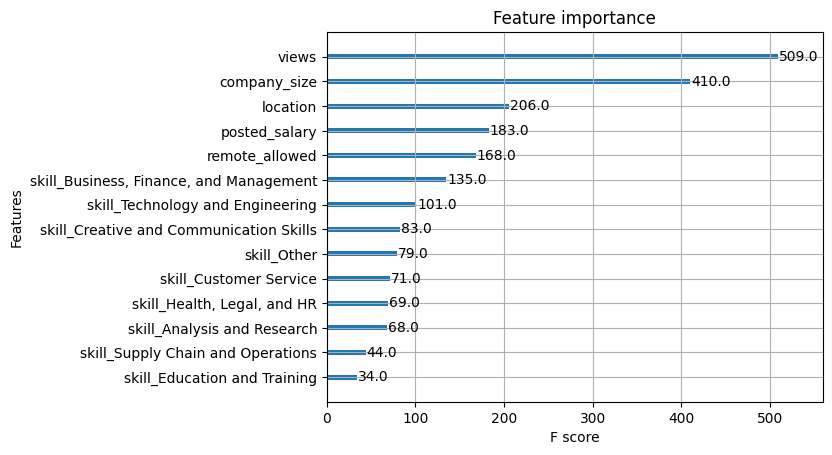

In [ ]:
plot_importance(xgboost_regressor, importance_type='weight')  # Options: 'weight', 'gain', 'cover'
plt.show()

We can notice the differences between the importance of different features in the XGBoost and Random Forest models. In XGBoost, company_size, location, posted_salary, and remote_allowed are a lot more important to the model than in Random Forest.

### **3.2.3 Grid Search for Hyperparameter Tuning**
For our XGBoost model, which predicts job applications, we performed a Grid Search to optimize key hyperparameters. By doing so, we aim to:
- Improve the model's generalizability (reduce overfitting or underfitting),
- Achieve higher accuracy in predictions,
- Ensure the model performs well on unseen data.

The best hyperparameters found during Grid Search will be used to train the final model, improving its ability to predict the number of job applications accurately.

By using Grid Search, we ensure that our XGBoost model is fine-tuned for optimal performance in predicting the number of applications.

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 6],
    'n_estimators': [50,100]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 18 candidates, totalling 90 fits


({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
 0.6731480949282909)

### **3.2.4 XGBoost with Hyperparameter Tuning**
After performing a Grid Search to optimize the hyperparameters of our XGBoost model, we identified the best combination of parameters to improve its performance.

**Goal:** The tuned XGBoost model aims to predict the number of job applications a posting receives with improved accuracy and generalizability, leveraging the best hyperparameter configuration obtained from the Grid Search.

We now train and evaluate the XGBoost model using these hyperparameters to assess its final performance.

In [ ]:
xgboost_regressor_new = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
xgboost_regressor_new.fit(X_train, y_train)

y_pred_xgb = xgboost_regressor_new.predict(X_test)

mse_xgb_new = mean_squared_error(y_test, y_pred_xgb)
mae_xgb_new = mean_absolute_error(y_test, y_pred_xgb)
training_r2_new = xgboost_regressor_new.score(X_train, y_train)
testing_r2_new = xgboost_regressor_new.score(X_test, y_test)
training_r2_new, testing_r2_new

(0.6983385530426306, 0.6685269786606292)

In [ ]:
k = 5
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error)
}

#perform 5-fold cross-validation with both metrics
cv_results = cross_validate(
    xgboost_regressor_new,
    X,
    y,
    cv=k,
    scoring=scoring,
    return_train_score=True
)

print("Train R² Scores (per fold):", cv_results['train_r2'])
print("Test R² Scores (per fold):", cv_results['test_r2'])
print("Train MAE Scores (per fold):", cv_results['train_mae'])
print("Test MAE Scores (per fold):", cv_results['test_mae'])

print("\nSummary Metrics:")
print("Mean Train R²:", cv_results['train_r2'].mean())
print("Mean Test R²:", cv_results['test_r2'].mean())
print("Mean Train MAE:", cv_results['train_mae'].mean())
print("Mean Test MAE:", cv_results['test_mae'].mean())

Train R² Scores (per fold): [0.71093191 0.68007971 0.69112413 0.68813358 0.70632192]
Test R² Scores (per fold): [0.58522683 0.67119156 0.64481007 0.69589248 0.56078679]
Train MAE Scores (per fold): [1.054189   0.9234319  0.98321338 1.045389   1.24451438]
Test MAE Scores (per fold): [1.09129529 1.60604964 1.35498939 1.10325999 0.2737532 ]

Summary Metrics:
Mean Train R²: 0.6953182526369205
Mean Test R²: 0.6315815462097063
Mean Train MAE: 1.0501475314067374
Mean Test MAE: 1.0858695019614462


###**3.2.5 Conclusion**
 - After applying the optimized hyperparameters, the model's mean training R² dropped to 0.695, **reflecting reduced overfitting.**
 - The mean test R² 0.631, similar to the baseline model, **confirming generalizability to unseen data**.
 - The mean MAE of the optimized model was 1.061, which is on par with the baseline model but slightly lower, indicating **slight improvements in prediction accuracy**.

Our XGBoost model has successfully addressed the overfitting issue that we observed in both the initial model and the optimized Random Forest model. The mean R² score has significantly improved compared to the unoptimized XGBoost model, bringing it in line with the performance of the optimized Random Forest model. However, this similarity suggests that decision tree-based models may have inherent limitations in their predictive capabilities for this problem. Moving forward, future efforts will focus on exploring alternative regression techniques to further enhance performance.








## **3.3 Neural Network**

**Motivation** Based on the results of our Random forest and XGBoost results, we can see that our R^2 is plateauing at around 0.64. We want to improve this metric, and potentially the MAE as well, but ensure that we do not overfit the model. Though neural networks tend to be more complex and result in overfitting, we plan to use Bayesian optimization to ensure that this is avoided.

**Evaluation Metrics**
We will use a combination of MAE (Mean Absolute Error), MSE (Mean Squared Error), and R². Using MAE, MSE, and R² together helps us understand how well the neural network predicts job applications from different angles:

- MAE (Mean Absolute Error): Tells us the average size of the errors in the predictions. It’s easy to understand because it’s in the same units as the target (e.g., number of applications).
- MSE (Mean Squared Error): Focuses more on big errors. If the model makes a large mistake, MSE will highlight it because it squares the errors.
- R² (R-squared): Shows how well the model explains the variation in the data. An R² closer to 1 means the model is doing a good job overall.

By using all three, we can check if the model makes small, consistent errors (MAE), avoids big mistakes (MSE), and captures the overall trend (R²). This gives a complete picture of the model's performance.

In [ ]:
X = encoded_postings_df.drop(columns=['applies'])
y = encoded_postings_df['applies']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

#define the neural network
class neuralNetwork(nn.Module):
    def __init__(self):
        super(neuralNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output layer
        )

    def forward(self, x):
        return self.fc(x)

#initialize the model, loss function, and optimizer
model = neuralNetwork()
criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

#evaluate on the test set
model.eval()
with torch.no_grad():
    # Get predictions
    test_predictions = model(X_test_tensor).squeeze().numpy()
    y_test_actual = y_test_tensor.squeeze().numpy()

    # Calculate metrics
    mse = mean_squared_error(y_test_actual, test_predictions)
    mae = mean_absolute_error(y_test_actual, test_predictions)
    r2 = r2_score(y_test_actual, test_predictions)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 43.3701
Mean Absolute Error (MAE): 1.4068
R² Score: 0.7493


###**3.3.1 K-Fold Cross-Validation**

K-Fold Cross-Validation splits the dataset into `k` equal parts (folds) to train and validate the model. In this example:
- The dataset is divided into 5 folds (`k = 5`), ensuring each fold is used once for validation while the remaining folds are used for training.
- The process loops through all folds, and metrics (MSE, MAE, R²) are calculated for both training and validation sets in each iteration.
- The final performance is reported as the mean and standard deviation of the metrics across all folds, providing a robust evaluation of the model’s performance.

This approach ensures the model is tested on all parts of the data, reducing overfitting and giving a more reliable estimate of its accuracy.


In [ ]:
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

num_epochs = 500
learning_rate = 0.001

train_mse_scores, train_mae_scores, train_r2_scores = [], [], []
val_mse_scores, val_mae_scores, val_r2_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):

    #split data into training and validation sets
    X_train_fold = X_tensor[train_idx]
    y_train_fold = y_tensor[train_idx]
    X_val_fold = X_tensor[val_idx]
    y_val_fold = y_tensor[val_idx]

    #initialize the model, loss function, and optimizer
    model = neuralNetwork()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_fold)
        loss = criterion(predictions, y_train_fold)
        loss.backward()
        optimizer.step()

    #calculate metrics for the training set
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_fold).squeeze().numpy()
        y_train_actual = y_train_fold.squeeze().numpy()

        train_mse = mean_squared_error(y_train_actual, train_predictions)
        train_mae = mean_absolute_error(y_train_actual, train_predictions)
        train_r2 = r2_score(y_train_actual, train_predictions)

        #metrics for the validation set
        val_predictions = model(X_val_fold).squeeze().numpy()
        y_val_actual = y_val_fold.squeeze().numpy()

        val_mse = mean_squared_error(y_val_actual, val_predictions)
        val_mae = mean_absolute_error(y_val_actual, val_predictions)
        val_r2 = r2_score(y_val_actual, val_predictions)


    #store the metrics
    train_mse_scores.append(train_mse)
    train_mae_scores.append(train_mae)
    train_r2_scores.append(train_r2)
    val_mse_scores.append(val_mse)
    val_mae_scores.append(val_mae)
    val_r2_scores.append(val_r2)

print("\nCross-Validation Results:")
print(f"Training   - Mean MSE: {np.mean(train_mse_scores):.4f}, Std: {np.std(train_mse_scores):.4f}")
print(f"             Mean MAE: {np.mean(train_mae_scores):.4f}, Std: {np.std(train_mae_scores):.4f}")
print(f"             Mean R²: {np.mean(train_r2_scores):.4f}, Std: {np.std(train_r2_scores):.4f}")
print(f"Validation - Mean MSE: {np.mean(val_mse_scores):.4f}, Std: {np.std(val_mse_scores):.4f}")
print(f"             Mean MAE: {np.mean(val_mae_scores):.4f}, Std: {np.std(val_mae_scores):.4f}")
print(f"             Mean R²: {np.mean(val_r2_scores):.4f}, Std: {np.std(val_r2_scores):.4f}")



Cross-Validation Results:
Training   - Mean MSE: 42.9277, Std: 3.0755
             Mean MAE: 1.4393, Std: 0.0345
             Mean R²: 0.7246, Std: 0.0123
Validation - Mean MSE: 46.2086, Std: 10.5425
             Mean MAE: 1.4571, Std: 0.0278
             Mean R²: 0.7019, Std: 0.0444


###**3.3.2 Bayesian Optimization for Hyperparameter Tuning**
Bayesian Optimization uses a probabilistic model to predict the performance of hyperparameter configurations and selects new configurations to evaluate based on these predictions.

###**How it works:**###
Bayesian Optimization uses the past performance of hyperparameter configurations to predict the performance of new configurations:

- It builds a probabilistic model (e.g., Gaussian Process) of the objective function based on observed results.
- It evaluates hyperparameters by balancing exploration (trying new values) and exploitation (refining known good values).
- It iteratively updates the probabilistic model to improve the search.

###**Why Bayesian Optimization?**###
Compared to grid or random search, Bayesian Optimization is more efficient and requires fewer trials to find a near-optimal solution. This is especially beneficial for expensive-to-train models like neural networks.

###**Weighted Sum Approach**
We combined the metrics (MSE, MAE, and R²) into a single objective function by assigning weights to each metric based on their importance. This allows us to optimize multiple metrics simultaneously.

**Objective** = w1 * MSE + w2 * MAE - w3 * R²

#### Why subtract R²?
- MSE and MAE are minimization metrics, meaning lower values are better.
- R² is a maximization metric, where higher values are better.
- By subtracting R², we align all metrics to be minimized, making it easier to combine them into a single objective.

This approach helps balance the importance of each metric in the optimization process.




In [ ]:
def objective(trial):
    #hyperparameters
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    num_epochs = trial.suggest_int("num_epochs", 100, 500)
    hidden_layer1 = trial.suggest_int("hidden_layer1", 32, 128, step=32)
    hidden_layer2 = trial.suggest_int("hidden_layer2", 16, 64, step=16)

    #define the nn
    class neuralNetwork(nn.Module):
        def __init__(self):
            super(neuralNetwork, self).__init__()
            self.fc = nn.Sequential(
                nn.Linear(X_train_tensor.shape[1], hidden_layer1),
                nn.ReLU(),
                nn.Linear(hidden_layer1, hidden_layer2),
                nn.ReLU(),
                nn.Linear(hidden_layer2, 1)
            )

        def forward(self, x):
            return self.fc(x)

    #initialize the model, loss function, and optimizer
    model = neuralNetwork()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

    #evaluate on the validation set
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor).squeeze().numpy()
        y_val_actual = y_test_tensor.squeeze().numpy()

        mse = mean_squared_error(y_val_actual, val_predictions)
        mae = mean_absolute_error(y_val_actual, val_predictions)
        r2 = r2_score(y_val_actual, val_predictions)

    #combine metrics into a single objective
    #adjust weights depending on importance
    w1, w2, w3 = 0.5, 0.3, 0.2
    objective_value = w1 * mse + w2 * mae - w3 * r2

    return objective_value

In [ ]:
#create an Optuna study
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)
print("Best validation MSE:", study.best_value)

[I 2024-12-09 18:53:34,876] A new study created in memory with name: no-name-e330e598-6379-43fd-b451-f476096d6785
[I 2024-12-09 18:53:59,583] Trial 0 finished with value: 34.27833757400513 and parameters: {'lr': 0.0006217306661559731, 'num_epochs': 267, 'hidden_layer1': 64, 'hidden_layer2': 64}. Best is trial 0 with value: 34.27833757400513.
[I 2024-12-09 18:54:31,697] Trial 1 finished with value: 21.875549864768985 and parameters: {'lr': 0.0019498567788493884, 'num_epochs': 253, 'hidden_layer1': 96, 'hidden_layer2': 48}. Best is trial 1 with value: 21.875549864768985.
[I 2024-12-09 18:54:52,443] Trial 2 finished with value: 69.29202605485916 and parameters: {'lr': 0.00015331619969521815, 'num_epochs': 476, 'hidden_layer1': 32, 'hidden_layer2': 48}. Best is trial 1 with value: 21.875549864768985.
[I 2024-12-09 18:55:37,538] Trial 3 finished with value: 38.87676783800125 and parameters: {'lr': 0.0006627088813240672, 'num_epochs': 245, 'hidden_layer1': 128, 'hidden_layer2': 16}. Best is 

Best hyperparameters: {'lr': 0.0038096637180733165, 'num_epochs': 241, 'hidden_layer1': 32, 'hidden_layer2': 16}
Best validation MSE: 21.737437546253204


In [ ]:
vis.plot_optimization_history(study).show()

vis.plot_param_importances(study).show()

#### **Results of Bayesian Optimization**
The Bayesian Optimization process helped improve the neural network's performance by tuning its hyperparameters. Here's what the results show:

1. **Optimization History Plot**:
   - The blue dots represent the performance of the neural network during each trial.
   - The red line shows the best performance (lowest objective value) achieved so far.
   - Over time, the objective value decreases as better hyperparameter settings are found.

2. **Hyperparameter Importances**:
   - The bar chart highlights which hyperparameters had the most influence on the model's performance.
   - **Learning rate (`lr`)** was the most important factor, accounting for 79% of the impact on the objective value.
   - **Number of epochs (`num_epochs`)** also had a noticeable effect, while the sizes of the hidden layers (`hidden_layer1` and `hidden_layer2`) contributed less.

In summary, the optimization process focused on the parameters that mattered most, primarily the learning rate and number of epochs, leading to an improved neural network.


###**3.3.3 Neural Network with Hyperparameter Tuning**

We will now apply the parameters determined by Bayesian Optimization to our new neural network model.

In [ ]:
#hyperparameters from Bayesian Optimization
best_params = {
    "lr": 0.0028981857354283234,
    "num_epochs": 445,
    "hidden_layer1": 96,
    "hidden_layer2": 48
}

#define the nn
class OptimizedNeuralNetwork(nn.Module):
    def __init__(self):
        super(OptimizedNeuralNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], best_params["hidden_layer1"]),
            nn.ReLU(),
            nn.Linear(best_params["hidden_layer1"], best_params["hidden_layer2"]),
            nn.ReLU(),
            nn.Linear(best_params["hidden_layer2"], 1)  # Output layer
        )

    def forward(self, x):
        return self.fc(x)

#initialize the model, loss function, and optimizer
model = OptimizedNeuralNetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])

#training loop
for epoch in range(best_params["num_epochs"]):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

#evaluate on the test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze().numpy()
    y_test_actual = y_test_tensor.squeeze().numpy()

    #calculate metrics
    mse = mean_squared_error(y_test_actual, test_predictions)
    mae = mean_absolute_error(y_test_actual, test_predictions)
    r2 = r2_score(y_test_actual, test_predictions)

mse, mae, r2


(43.977093, 1.3648139, 0.7457411289215088)

We will repeat K-fold cross validation to get accurate measures of our evaluation statistics

In [ ]:
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

num_epochs = best_params['num_epochs']
learning_rate = best_params['lr']

train_mse_scores, train_mae_scores, train_r2_scores = [], [], []
val_mse_scores, val_mae_scores, val_r2_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):

    #split data into training and validation sets
    X_train_fold = X_tensor[train_idx]
    y_train_fold = y_tensor[train_idx]
    X_val_fold = X_tensor[val_idx]
    y_val_fold = y_tensor[val_idx]

    #initialize the model, loss function, and optimizer
    model = OptimizedNeuralNetwork()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_fold)
        loss = criterion(predictions, y_train_fold)
        loss.backward()
        optimizer.step()

    #calculate metrics for the training set
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_fold).squeeze().numpy()
        y_train_actual = y_train_fold.squeeze().numpy()

        train_mse = mean_squared_error(y_train_actual, train_predictions)
        train_mae = mean_absolute_error(y_train_actual, train_predictions)
        train_r2 = r2_score(y_train_actual, train_predictions)

        #calculate metrics for the validation set
        val_predictions = model(X_val_fold).squeeze().numpy()
        y_val_actual = y_val_fold.squeeze().numpy()

        val_mse = mean_squared_error(y_val_actual, val_predictions)
        val_mae = mean_absolute_error(y_val_actual, val_predictions)
        val_r2 = r2_score(y_val_actual, val_predictions)


    #store the metrics
    train_mse_scores.append(train_mse)
    train_mae_scores.append(train_mae)
    train_r2_scores.append(train_r2)
    val_mse_scores.append(val_mse)
    val_mae_scores.append(val_mae)
    val_r2_scores.append(val_r2)

print("\nCross-Validation Results:")
print(f"Training   - Mean MSE: {np.mean(train_mse_scores):.4f}, Std: {np.std(train_mse_scores):.4f}")
print(f"             Mean MAE: {np.mean(train_mae_scores):.4f}, Std: {np.std(train_mae_scores):.4f}")
print(f"             Mean R²: {np.mean(train_r2_scores):.4f}, Std: {np.std(train_r2_scores):.4f}")
print(f"Validation - Mean MSE: {np.mean(val_mse_scores):.4f}, Std: {np.std(val_mse_scores):.4f}")
print(f"             Mean MAE: {np.mean(val_mae_scores):.4f}, Std: {np.std(val_mae_scores):.4f}")
print(f"             Mean R²: {np.mean(val_r2_scores):.4f}, Std: {np.std(val_r2_scores):.4f}")



Cross-Validation Results:
Training   - Mean MSE: 34.2138, Std: 1.9978
             Mean MAE: 1.1636, Std: 0.0304
             Mean R²: 0.7803, Std: 0.0099
Validation - Mean MSE: 46.6408, Std: 10.4111
             Mean MAE: 1.2250, Std: 0.0374
             Mean R²: 0.6971, Std: 0.0537


###**3.3.4 Conclusion**

- R^2 is higher than XGBoost and Random Forest for test set, but not too much better than the unoptimized model
  - Overall the Bayesian optimization did not improve the model too much
- The model explains 71% of the variance in the number of applies based on our features of location, remote posting, salary posting, company size, and skills
  - This is relatively strong, but 29% of the variance is unexplained
- Our model’s predictions deviate from actual values by 1.14 applications
  - Given that our range of applications are from 0 to 25, this is an acceptable number


## **Part 4: Conclusion and Discussion**
**Key Takeaways**
- Remote jobs attract significantly more applications than non-remote jobs
- Number of views is a critical predictor of job applications across models, with its importance being most pronounced in Random Forest and XGBoost. Visibility drives application numbers
- Location and company size are key factors influencing applications in XGBoost, with more applications generally seen in popular locations and larger companies.
- Skill category plays a limited role in predicting the number of applications
- The relationship between features and applications is non-linear, which aligns with the strengths of models like Random Forest, XGBoost, and Neural Networks
- The Neural Network demonstrated the highest predictive power (R² = 0.71) and minimized overfitting

**Limitations of Models**
- Neural Network
  - High Risk of Overfitting, though it appears that we don't have this issue given R² scores
  - Needs a lot of data
  - Hard to interpret
- Random Forest
  - Highly overfit the model
  - Overemphasised certain features (i.e. views)
- XGBoost
  - Lowest R² and MAE

**Future Work**
- Data improvements:
  - Create new features (ex. include job description keywords) to better predict applications
  - Incorporate additional data
  - Ensure balanced representation of different job categories and locations to reduce model bias
- Neural Network Optimization:
  - Explore alternative architectures, such as recurrent or attention-based models

**Additional Notes for Grading**
- For application of class topics, we included Pandas, Regex, Join, Supervised Learning, and Hypothesis Testing (Permutation testing)
- For the difficulty section, we chose to do advanced feature engineering (for location and skills), Bayesian Optimization, and Hypothesis Testing